s1_mu_gibbs = 55.172186, s2_mu_gibbs = 44.589127
s1_mu_MM = 52.968512, s2_mu_MM = 47.031488
s1_var_gibbs = 4.761701, s2_var_gibbs = 4.660214
s1_var_MM = 3.928137, s2_var_MM = 3.928137
alpha = 40.015262, beta = 181.331792


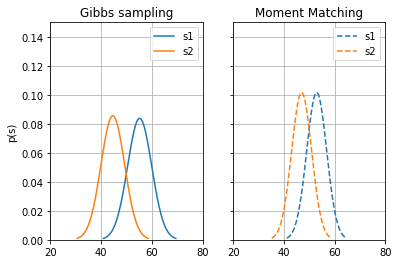

In [132]:
# Libraries
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import time

def gibbs_sampler(mu_1, mu_2, sigma_1, sigma_2, sigma_t, y, num_samples, burn_in):
    # Number of samples k
    k = num_samples
    
    # Storing vectors
    s_1 = np.zeros(burn_in+k)
    s_2 = np.zeros(burn_in+k)
    out = np.zeros(burn_in+k)
    
    # Set initial values
    s_1[0] = np.random.normal(mu_1, sigma_1)
    s_2[0] = np.random.normal(mu_2, sigma_2)
    
    for i in range(burn_in+k-1):
        mu_t = s_1[i] - s_2[i]
        if(y == 1):
            a, b = (0-mu_t)/sigma_t, np.infty
        else:
            a, b = -np.infty, (0-mu_t)/sigma_t
        # Calculate the output   
        out[i+1] = stats.truncnorm.rvs(a,b,loc=mu_t,scale=sigma_t)
        # Get sigma and Mu from the posterior to calculate the new prior
        Sigma = 1/(sigma_1+sigma_2+sigma_t)*np.matrix([[sigma_1*(sigma_2+sigma_t), sigma_1*sigma_2], \
                                                       [sigma_1*sigma_2, sigma_2*(sigma_1+sigma_t)]])
        Mu = np.matmul(Sigma, np.matrix([[mu_1/sigma_1+out[i+1]/sigma_t], [mu_2/sigma_2-out[i+1]/sigma_t]]))
        # Generate the new skills
        s_1[i+1], s_2[i+1] = np.random.multivariate_normal(list(Mu.flat), Sigma)
    
    # Discard burn-in samples
    s_1 = s_1[burn_in:-1]
    s_2 = s_2[burn_in:-1]
    
    return s_1, s_2, out

# Parameters
mu_BOTH = 50
sigma_BOTH = mu_BOTH/3
mu_1 = mu_BOTH
mu_2 = mu_BOTH
mu_t = mu_1 - mu_2
sigma_1 = sigma_BOTH
sigma_2 = sigma_BOTH
sigma_t = 10
sigmas = sigma_1 + sigma_2 + sigma_t
y = 1
num_samples = 500
burn_in = 25

# Get approximated from Gibbs sampler
s1,s2,out = gibbs_sampler(mu_1, mu_2, sigma_1, sigma_2, sigma_t, y, num_samples, burn_in)

# Approx Gaussian s1 with Gibbs
mu_approx_s1 = np.mean(s1)
var_approx_s1 = np.var(s1)
sigma_approx_s1 = np.sqrt(var_approx_s1)
x_approx_s1 = np.linspace(mu_approx_s1 - 3*sigma_approx_s1, mu_approx_s1+ 3*sigma_approx_s1, num_samples)

# Approx Gaussian s2 with Gibbs
mu_approx_s2 = np.mean(s2)
var_approx_s2 = np.var(s2)
sigma_approx_s2 = np.sqrt(var_approx_s2)
x_approx_s2 = np.linspace(mu_approx_s2 - 3*sigma_approx_s2, mu_approx_s2 + 3*sigma_approx_s2, num_samples)


# Get samples from truncated Gaussian
truncGaussian = stats.truncnorm.rvs((0-mu_t)/sigma_t, np.infty, loc=mu_t, scale=sigma_t, size=num_samples)
m_star = np.mean(truncGaussian)
sigma_star = np.var(truncGaussian)

alpha = (m_star*sigmas - mu_t*sigma_star)/(sigmas - sigma_star)
beta = sigma_star*sigmas/(sigmas - sigma_star)

# Get posteriors with moment matching
# s1 with moment matching
s1_mu = ((alpha + mu_2)*sigma_1 + mu_1*(beta + sigma_t + sigma_2))/(sigmas + beta)
s1_var = sigma_1*(beta + sigma_t + sigma_2)/(sigmas + beta)
s1_sigma = np.sqrt(s1_var)
x_s1 = np.linspace(s1_mu - 3*s1_sigma, s1_mu + 3*s1_sigma, num_samples)
normal_s1 = stats.norm.pdf(x_s1, s1_mu, s1_sigma)

# s2 with moment matching
s2_mu = ((-alpha + mu_1)*sigma_2 + mu_2*(beta + sigma_t + sigma_1))/(sigmas + beta)
s2_var = sigma_2*(beta + sigma_t + sigma_1)/(sigmas + beta)
s2_sigma = np.sqrt(s2_var)
x_s2 = np.linspace(s2_mu - 3*s2_sigma, s2_mu + 3*s2_sigma, num_samples)
normal_s2 = stats.norm.pdf(x_s2, s2_mu, s2_sigma)

# Plot everything
fig, axs = plt.subplots(1, 2)

axs[0].plot(x_approx_s1, stats.norm.pdf(x_approx_s1, mu_approx_s1, sigma_approx_s1), label='s1')
axs[0].plot(x_approx_s2, stats.norm.pdf(x_approx_s2, mu_approx_s2, sigma_approx_s2), label='s2')
axs[0].set_title('Gibbs sampling')
axs[0].set(ylabel='p(s)') 
axs[1].plot(x_s1, normal_s1, label='s1', color='C0', linestyle='dashed')
axs[1].plot(x_s2, normal_s2, label='s2', color='C1', linestyle='dashed')
axs[1].set_title('Moment Matching')

# Plot settings
for ax in axs.flat:
    ax.set(xlim=[20,80],ylim=[0,0.15])
    ax.label_outer()
    ax.legend()
    ax.grid(True)

# Print the values generated
print('s1_mu_gibbs = %f, s2_mu_gibbs = %f\ns1_mu_MM = %f, s2_mu_MM = %f' %(mu_approx_s1, mu_approx_s2, s1_mu, s2_mu))
print('s1_var_gibbs = %f, s2_var_gibbs = %f\ns1_var_MM = %f, s2_var_MM = %f' %(sigma_approx_s1, sigma_approx_s2, s1_sigma, s2_sigma))
print('alpha = %f, beta = %f' % (alpha, beta))

# Show it
plt.savefig('gaussian_approx_with_Gibbs_and_MM.pdf', format='pdf')
plt.show()